<a href="https://colab.research.google.com/github/shashankbhagat/Earthquake-Prediction/blob/master/EarthQuake_decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
pd.set_option('display.max_columns',None)

In [34]:
data=pd.read_csv('database.csv')
data.head()

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,Magnitude Error,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,01/02/1965,13:44:18,19.246,145.616,Earthquake,131.6,NaN,NaN,6.0,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,01/04/1965,11:29:49,1.863,127.352,Earthquake,80.0,NaN,NaN,5.8,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,20.0,NaN,NaN,6.2,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic
3,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,15.0,NaN,NaN,5.8,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic
4,01/09/1965,13:32:50,11.938,126.427,Earthquake,15.0,NaN,NaN,5.8,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic


In [35]:
data.dtypes

Date                           object
Time                           object
Latitude                      float64
Longitude                     float64
Type                           object
Depth                         float64
Depth Error                   float64
Depth Seismic Stations        float64
Magnitude                     float64
Magnitude Type                 object
Magnitude Error               float64
Magnitude Seismic Stations    float64
Azimuthal Gap                 float64
Horizontal Distance           float64
Horizontal Error              float64
Root Mean Square              float64
ID                             object
Source                         object
Location Source                object
Magnitude Source               object
Status                         object
dtype: object

# Data Analysis

Before starting with the analysis, we would be scaling the input. Espicially the Date and Time fields to Unix time which is in seconds.

In [36]:
import datetime
import time

timestamp=[]
for d,t in zip(data['Date'],data['Time']):
    try:
        ts=datetime.datetime.strptime(d+' '+t,'%m/%d/%Y %H:%M:%S')
        timestamp.append(time.mktime(ts.timetuple()))
    except ValueError:
        timestamp.append('ValueError')

In [37]:
data['TimeStamp']=timestamp
data.drop(columns=['Date','Time'],axis=1,inplace=True)
data.head()

,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,Magnitude Error,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status,TimeStamp
0,19.246,145.616,Earthquake,131.6,NaN,NaN,6.0,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic,-1.57631e+08
1,1.863,127.352,Earthquake,80.0,NaN,NaN,5.8,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic,-1.57466e+08
2,-20.579,-173.972,Earthquake,20.0,NaN,NaN,6.2,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic,-1.57356e+08
3,-59.076,-23.557,Earthquake,15.0,NaN,NaN,5.8,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic,-1.57094e+08
4,11.938,126.427,Earthquake,15.0,NaN,NaN,5.8,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic,-1.57026e+08


Missing Values

In [38]:
## list of features with NA
features_with_na=[feature for feature in data.columns if data[feature].isnull().sum()>0]

for feature in features_with_na:
    print(feature,np.round(data[feature].isnull().sum()/len(data[feature])*100,4),' %missing values')

Depth Error 80.9457  %missing values
Depth Seismic Stations 69.6865  %missing values
Magnitude Type 0.0128  %missing values
Magnitude Error 98.6033  %missing values
Magnitude Seismic Stations 89.0484  %missing values
Azimuthal Gap 68.8237  %missing values
Horizontal Distance 93.1488  %missing values
Horizontal Error 95.0624  %missing values
Root Mean Square 25.8842  %missing values


In [39]:
## Features having missing values for more than 50%. So we must drop those features.
for feature in features_with_na:
    if (data[feature].isnull().sum()/len(data[feature]))*100>50:
        data.drop(columns=feature,inplace=True)

data.head()

,Latitude,Longitude,Type,Depth,Magnitude,Magnitude Type,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status,TimeStamp
0,19.246,145.616,Earthquake,131.6,6.0,MW,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic,-1.57631e+08
1,1.863,127.352,Earthquake,80.0,5.8,MW,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic,-1.57466e+08
2,-20.579,-173.972,Earthquake,20.0,6.2,MW,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic,-1.57356e+08
3,-59.076,-23.557,Earthquake,15.0,5.8,MW,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic,-1.57094e+08
4,11.938,126.427,Earthquake,15.0,5.8,MW,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic,-1.57026e+08


In [40]:
## updated list of features with NA
features_with_na=[feature for feature in data.columns if data[feature].isnull().sum()>0]
features_with_na

['Magnitude Type', 'Root Mean Square']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # Remove the CWD from sys.path while we load stuff.


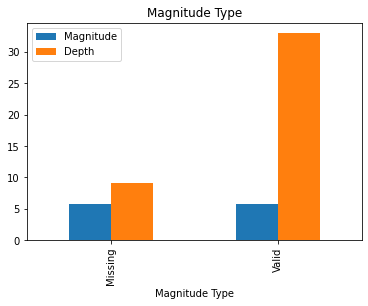

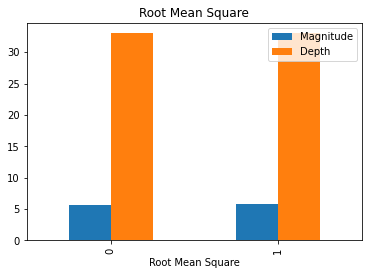

In [44]:
## Relation between remaining valid NA features and dependent feature

for feature in features_with_na:
    data_temp=data.copy()
    if data_temp[feature].dtype=='O':
        data_temp[feature]=np.where(data_temp[feature].isnull(),'Missing','Valid')
    else:
        data_temp[feature]=np.where(data_temp[feature].isnull(),1,0)

    data_temp.groupby(data_temp[feature])['Magnitude','Depth'].median().plot.bar()
    plt.title(feature)
    plt.show()


Here the missing values are significant compared to the Magnitude (dependent feature). So the decision to directly drop them would not be good. So, we would check in feature engineering and feature selection process.

In [42]:
data['Magnitude Type'].dtype=='O'

True